In [ ]:
import warnings
warnings.filterwarnings('ignore')
from IPython.display import display 

In [1]:
import numpy as np    
import pandas as pd                    
import matplotlib.pyplot as plt      
import seaborn as sns                
import re                      

# Исследованик рынка общественного питания в Москве

Для того, чтобы открыть небольшое кафе в котором официантов заменят роботы, в Москве, необходимо проанализировать рынок общественного питания. Все это в целях определения перспективности столь дорогостоящего проекта. Имея в наличии открытые дынне о заведениях расположенных в Москве. Определим наиболее распространненые типы заведений, плотность их распределения по территориям, а так же насколько отдельные заведения большие и др. Все эти данные позволят спроектировать наиболее оптимальную бизнесс стратегию по расположению и величине нового заведения, что в свою очередь повысит симпатии инвесторов.

## Загрузка данных и подготовка к анализу

Выгрузим имеющиеся данные из файла и произведем их пердобработку, на наличие пропусков, дубликатов, а так же проверим типы используемых данных:

In [2]:
df = pd.read_csv('/datasets/rest_data.csv')
df

,id,object_name,chain,object_type,address,number
0,151635,СМЕТАНА,нет,кафе,"город Москва, улица Егора Абакумова, дом 9",48
1,77874,Родник,нет,кафе,"город Москва, улица Талалихина, дом 2/1, корпус 1",35
2,24309,Кафе «Академия»,нет,кафе,"город Москва, Абельмановская улица, дом 6",95
3,21894,ПИЦЦЕТОРИЯ,да,кафе,"город Москва, Абрамцевская улица, дом 1",40
4,119365,Кафе «Вишневая метель»,нет,кафе,"город Москва, Абрамцевская улица, дом 9, корпус 1",50
...,...,...,...,...,...,...
15361,208537,Шоколадница,да,кафе,"город Москва, 3-й Крутицкий переулок, дом 18",50
15362,209264,Шоколадница,да,кафе,"город Москва, улица Земляной Вал, дом 33",10
15363,209186,Шоколадница,да,кафе,"город Москва, улица Земляной Вал, дом 33",20
15364,221900,Шоколадница,да,кафе,"город Москва, поселение Московский, Киевское ш...",36


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15366 entries, 0 to 15365
Data columns (total 6 columns):
id             15366 non-null int64
object_name    15366 non-null object
chain          15366 non-null object
object_type    15366 non-null object
address        15366 non-null object
number         15366 non-null int64
dtypes: int64(2), object(4)
memory usage: 720.4+ KB


In [4]:
print(f'Количество дубликатов: {df.duplicated().sum()}')

Количество дубликатов: 0


Пропущенные значения отсутствуют, все типы данных соответствуют требуемым, очевидных дубликатов нет. Однако, что если одному заведению присвоили разный ID или записали различное количество посадочных мест, все же данные из разных источников. Произведем проверку на наличие дубликатов без столбцов ID и number:

In [5]:
print(f'Количество дубликатов: {df[["object_name", "chain", "object_type", "address"]].duplicated().sum()}')

Количество дубликатов: 170


Оказывается дубликаты присутствуют, избавимся от них. Для продублированных заведений в качестве ID возьмем первый, а для показателя посадочных мест возьмем медиану:

In [6]:
df = df.groupby(['address', 'object_name', 'object_type', 'chain']).agg({'id' : 'first', 'number' : 'median'}).reset_index()
df = df.reindex(columns=['id', 'object_name', 'chain', 'object_type', 'address', 'number'])
df['number'] = df['number'].astype('int')
df

,id,object_name,chain,object_type,address,number
0,132359,Кафе «La Carotte»,нет,кафе,"1-й Нагатинский проезд, дом 10",198
1,25036,ЯКИТОРИЯ,да,кафе,"1-я Тверская-Ямская улица, дом 29/66, корпус 1",456
2,26477,Ресторан «2545»,нет,ресторан,"2-я Брестская улица, дом 1, строение 1",30
3,178003,Столовая,нет,столовая,"2-я Брестская улица, дом 5, строение 1",30
4,83951,Бункер 42 на Таганке,нет,ресторан,"5-й Котельнический переулок, дом 11",271
...,...,...,...,...,...,...
15191,193080,Buba by Sumosan,нет,кафе,"улица Льва Толстого, дом 18",80
15192,193058,HANG KONG,нет,кафе,"улица Льва Толстого, дом 18",70
15193,158670,Макдоналдс,да,кафе,"улица Миклухо-Маклая, дом 18",110
15194,114367,СТОЛОВАЯ при Автокомбинате № 12,нет,столовая,"улица Обручева, дом 23, строение 1",40


Данные прошли предобработку, и теперь можно приступать к их анализу.

## Анализ данных

Для того, чтобы ответить на поставленные в проекте вопросы рассмотрим данные с разных сторон и в разных разрезах. В этом нам помогут множественные способы визуализации из библиотеки seaborn.

###  Соотношение видов объектов общественного питания по количеству

Рассмотрим какие типы заведений наиболее популярны и пользуются спросом:

In [7]:
object_type = df['object_type'].value_counts().reset_index()
object_type

,index,object_type
0,кафе,6017
1,столовая,2575
2,ресторан,2276
3,предприятие быстрого обслуживания,1891
4,бар,853
5,буфет,571
6,кафетерий,393
7,закусочная,348
8,магазин (отдел кулинарии),272


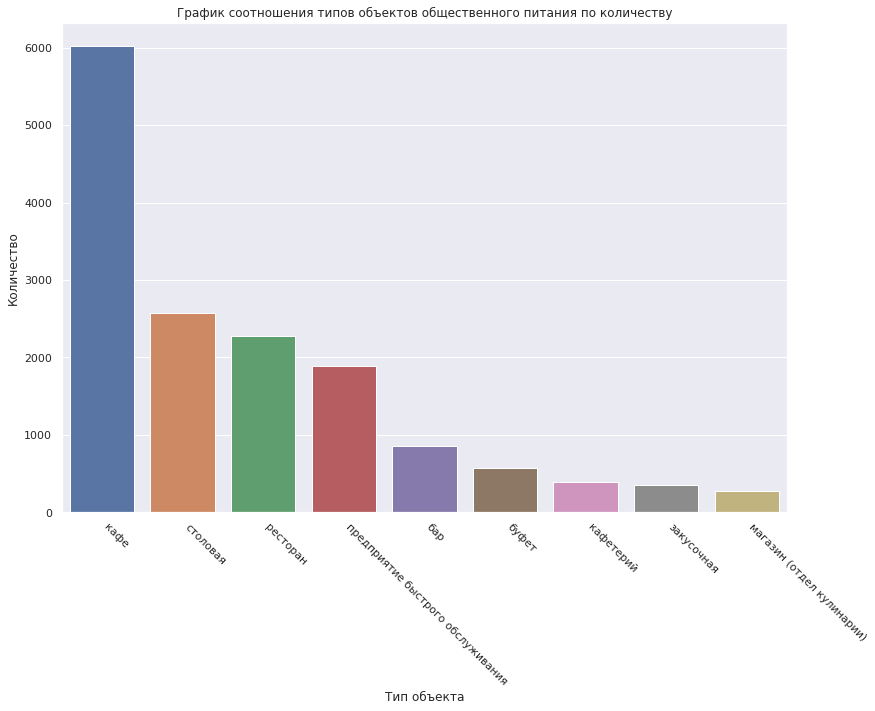

In [8]:
sns.set(style='darkgrid')
fig,ax = plt.subplots(figsize=(13, 9))
sns.barplot(x='index', y='object_type', data = object_type)
ax.set_xticklabels(object_type['index'], rotation=-45, ha='left')
plt.title('График соотношения типов объектов общественного питания по количеству')
plt.xlabel('Тип объекта')
plt.ylabel('Количество')
plt.show()

Имеется абсолютный лидер - это кафе. Самый популярный и востребованный, более 6000 заведений по Москве.

###  Соотношение сетевых и несетевых заведений по количеству

Теперь определим какие заведения преобладают, те которые являются частью большой сети или же независимые ресторанчики:

In [9]:
chain = df['chain'].value_counts().reset_index()
chain.columns = ['chain', 'count']
chain

,chain,count
0,нет,12245
1,да,2951


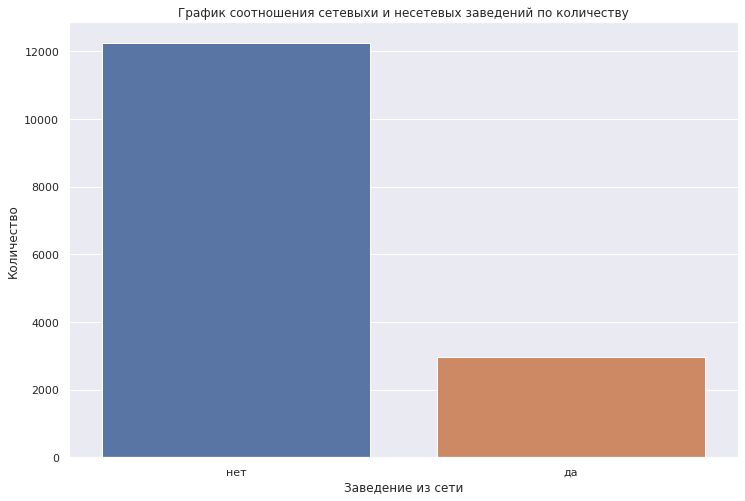

In [10]:
plt.figure(figsize=(12, 8))
sns.barplot(x ='chain', y = 'count', data = chain)
plt.title('График соотношения сетевыхи и несетевых заведений по количеству')
plt.xlabel('Заведение из сети')
plt.ylabel('Количество')
plt.show()

Заведений принадлежащих сети не очень то и много, по отношению к самостоятельным. Видимо все стараются развивать свое дело независимо от других.

###  Вид объекта общественного питания с сетевым распространением

Рассмотрим подробнее как же сети заведений распределены типы объектов общественного питания:

In [11]:
chain_object = df[df['chain'] == 'да']
chain_object = chain_object['object_type'].value_counts().reset_index()
chain_object.columns = ['object_type', 'count']
chain_object

,object_type,count
0,кафе,1389
1,предприятие быстрого обслуживания,784
2,ресторан,542
3,магазин (отдел кулинарии),78
4,закусочная,56
5,кафетерий,51
6,бар,37
7,буфет,11
8,столовая,3


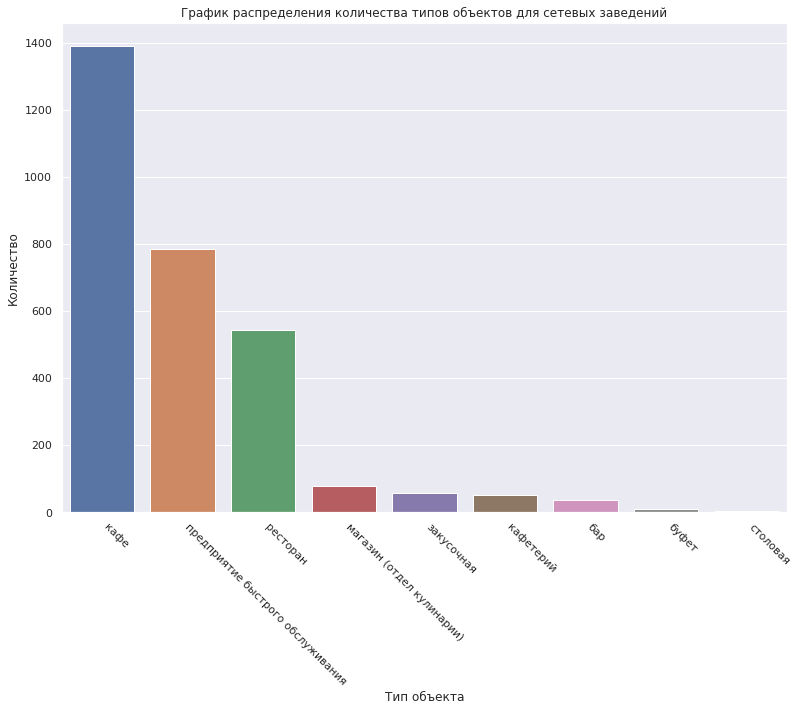

In [12]:
fig,ax = plt.subplots(figsize=(13, 9))
sns.barplot(x='object_type', y='count', data=chain_object)
ax.set_xticklabels(chain_object['object_type'], rotation=-45, ha='left')
plt.title('График распределения количества типов объектов для сетевых заведений')
plt.xlabel('Тип объекта')
plt.ylabel('Количество')
plt.show()

И снова кафе - топ-1, а вот столовые которые по всем данным занимали второе место, теперь в самом конце, выдимо такой тип заведение совсем неподходит большим сетям.

###  Вид объекта общественного питания с сетевым распространением

Интересно узнать какой формат заведений преобладает в сетях: большие заведения в малом количестве, или же большое количество некрупных заведений. Используя данные о количестве посадочных мест в каждом объекте общественного питания, ответим на поставленный вопрос.

Сгруппируем данные по названию сети, определим среднее количество мест в ее заведениях, и построим диаграмму рассеяния. Но для качественной группировки по названию сети, необходимо сначала обработать столбец с названями заведений:

In [13]:
object_name = df[df['chain'] == 'да'].copy()
object_name['object_name'] = object_name['object_name'].str.lower()    

gr_object_name = (object_name.groupby('object_name').agg({'id' : 'count'}) 
                  .sort_values(by='id', ascending=False).reset_index()
                 )
gr_object_name.columns = ['object_name', 'count']
top = gr_object_name.head(30)['object_name'].unique()    
gr_object_name

,object_name,count
0,шоколадница,155
1,kfc,155
2,макдоналдс,148
3,бургер кинг,136
4,теремок,94
...,...,...
572,кафе «торнадо»,1
573,кафе «тапчан»,1
574,кафе «тануки»,1
575,кафе «суши сет»,1


In [14]:
names = list(top)                                                    
str_pat_name = r".*\s*\b([^,]*?(?:{})\b)".format("|".join(top))  

object_name['name'] = object_name['object_name'].str.extract(str_pat_name, flags = re.I) 

In [15]:
def fill(row):                                           #функция для заполнения пропусков в столбце 'name' старыми названиями
    if row['name'] == ' ':
        return row['object_name']
    else:
        return row['name']

In [16]:
object_name = object_name.fillna(' ')                                
object_name['name'] = object_name.apply(fill, axis=1)               

gr_object_name = (object_name.groupby('name').agg({'id' : 'count', 'number' : 'mean'})  
                  .sort_values(by='id', ascending=False).reset_index()                  
                 )  

gr_object_name.columns = ['object_name', 'count', 'average_number']
gr_object_name['average_number'] = gr_object_name['average_number'].round().astype('int')
gr_object_name

,object_name,count,average_number
0,kfc,187,56
1,шоколадница,181,58
2,макдоналдс,170,88
3,бургер кинг,158,48
4,теремок,111,27
...,...,...,...
418,кафе космик,1,10
419,кафе волконский пекарня,1,22
420,кафе «чайхана тапчан»,1,102
421,кафе «урюк» хивинская чайхона,1,50


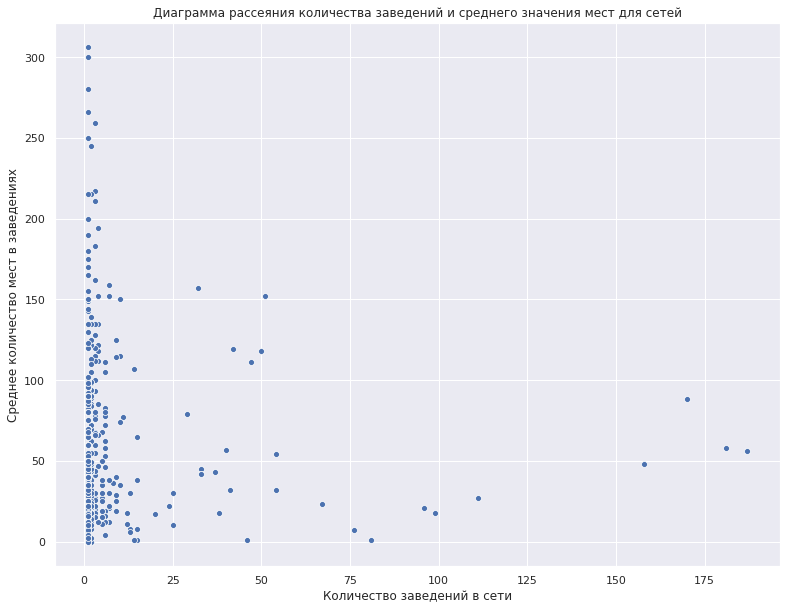

In [17]:
plt.figure(figsize=(13, 10))
sns.scatterplot(x='count', y='average_number', data=gr_object_name)
plt.title('Диаграмма рассеяния количества заведений и среднего значения мест для сетей')
plt.xlabel('Количество заведений в сети')
plt.ylabel('Среднее количество мест в заведениях')
plt.show()

Похоже для сетевых заведений более преимущественна политика небольшого числа заведений с большим числом мест по возможности. Однако очень крупные сети, наоборот стараются увеличивать число заведений и зачастую не самых крупных.

###  Среднее количество посадочных мест для каждого вида объекта общественного питания

Оценим какое в среднем количество мест имеется в заведении определенного типа. Сгруппируем данные по видам, и найедем медианное (так как количество заведений по каждому типу распределенно неравномерно) значение по столбцу 'number':

In [18]:
df_grouped = df.groupby('object_type').agg({'number' : 'median'}).reset_index()
df_grouped

,object_type,number
0,бар,35
1,буфет,32
2,закусочная,0
3,кафе,32
4,кафетерий,6
5,магазин (отдел кулинарии),0
6,предприятие быстрого обслуживания,6
7,ресторан,80
8,столовая,103


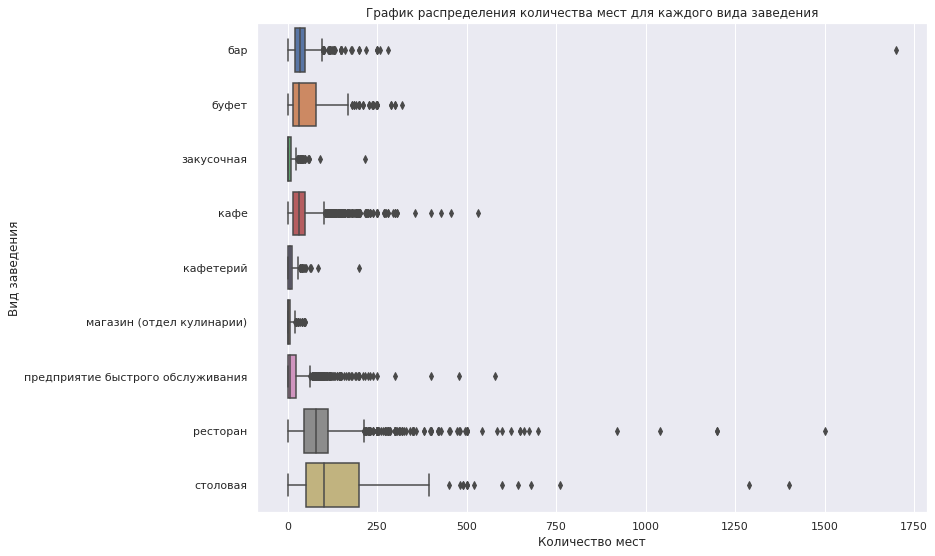

In [19]:
plt.figure(figsize=(12, 9))
sns.boxplot(x='number', y='object_type', data=df, order=df_grouped['object_type'].tolist())
plt.title('График распределения количества мест для каждого вида заведения')
plt.xlabel('Количество мест')
plt.ylabel('Вид заведения')
plt.show()

Самое большое количество мест в среднем предосталяют в столовых, аж целых 103 места приходится на одну среднюю столовую.

###  Выделение названия улицы в отдельный столбец

Чтобы проанализировать как распределены заведения по местоположению, нужно выделить названия улицы из столбца с адресом местонахождения заведения. Выполним это с помощью регулярных выражений:

In [20]:
words = ['улица','ул','переулок','шоссе','проспект','площадь','проезд',
         'село','аллея','бульвар','набережная','тупик','линия', 'просек',
         'километр', 'квартал', 'деревня', 'территория', 'посёлок', 'микрорайон', 'поселение']

str_pat = r"([^,]*?(?:{})\b[^,]*)[,$]+".format("|".join(words))

df['street'] = df['address'].str.extract(str_pat, flags = re.I)
df

,id,object_name,chain,object_type,address,number,street
0,132359,Кафе «La Carotte»,нет,кафе,"1-й Нагатинский проезд, дом 10",198,1-й Нагатинский проезд
1,25036,ЯКИТОРИЯ,да,кафе,"1-я Тверская-Ямская улица, дом 29/66, корпус 1",456,1-я Тверская-Ямская улица
2,26477,Ресторан «2545»,нет,ресторан,"2-я Брестская улица, дом 1, строение 1",30,2-я Брестская улица
3,178003,Столовая,нет,столовая,"2-я Брестская улица, дом 5, строение 1",30,2-я Брестская улица
4,83951,Бункер 42 на Таганке,нет,ресторан,"5-й Котельнический переулок, дом 11",271,5-й Котельнический переулок
...,...,...,...,...,...,...,...
15191,193080,Buba by Sumosan,нет,кафе,"улица Льва Толстого, дом 18",80,улица Льва Толстого
15192,193058,HANG KONG,нет,кафе,"улица Льва Толстого, дом 18",70,улица Льва Толстого
15193,158670,Макдоналдс,да,кафе,"улица Миклухо-Маклая, дом 18",110,улица Миклухо-Маклая
15194,114367,СТОЛОВАЯ при Автокомбинате № 12,нет,столовая,"улица Обручева, дом 23, строение 1",40,улица Обручева


In [21]:
def del_space(row):                              #функция по удалению лишнихо пробелов в начале и в конце названия улицы
    try:
        return row['street'].strip()
    except:
        pass

df['street'] = df.apply(del_space, axis=1)

Теперь в датафрэйме имеется столбец с названием улицы на которой объект находится. Он необходим для дальнейших расчетов.

###  Определение топ-10 улиц с наибольшим количеством заведений

Составим рейтинг улиц на которых имеется самое большое количество объектов общественного питания, и с помощью внешних источников информации определим в каких районах Москвы эти улицы находятся:

In [22]:
URL = 'https://frs.noosphere.ru/xmlui/bitstream/handle/20.500.11925/714058/mosgaz-streets.csv?sequence=1&isAllowed=y'
district = pd.read_csv(URL)                                                  #выгрузка данных из внешнего источника
district

,streetname,areaid,okrug,area
0,Выставочный переулок,17,ЦАО,Пресненский район
1,улица Гашека,17,ЦАО,Пресненский район
2,Большая Никитская улица,17,ЦАО,Пресненский район
3,Глубокий переулок,17,ЦАО,Пресненский район
4,Большой Гнездниковский переулок,17,ЦАО,Пресненский район
...,...,...,...,...
4393,Вознесенский проезд,17,ЦАО,Пресненский район
4394,Волков переулок,17,ЦАО,Пресненский район
4395,Поварская улица,17,ЦАО,Пресненский район
4396,Кудринская площадь,17,ЦАО,Пресненский район


In [23]:
district = district.drop(columns=['areaid', 'okrug'])

In [24]:
district.columns = ['street', 'area']
district.head()

,street,area
0,Выставочный переулок,Пресненский район
1,улица Гашека,Пресненский район
2,Большая Никитская улица,Пресненский район
3,Глубокий переулок,Пресненский район
4,Большой Гнездниковский переулок,Пресненский район


In [25]:
union = df.merge(district, on='street') 
union

,id,object_name,chain,object_type,address,number,street,area
0,132359,Кафе «La Carotte»,нет,кафе,"1-й Нагатинский проезд, дом 10",198,1-й Нагатинский проезд,Район Нагатино-Садовники
1,140510,Ресторан «Клюква»,нет,ресторан,"город Москва, 1-й Нагатинский проезд, дом 10, ...",100,1-й Нагатинский проезд,Район Нагатино-Садовники
2,146717,Кафе «SKYFOOD»,нет,кафе,"город Москва, 1-й Нагатинский проезд, дом 11, ...",8,1-й Нагатинский проезд,Район Нагатино-Садовники
3,168333,Ресторан «Счастливая Щука»,нет,ресторан,"город Москва, 1-й Нагатинский проезд, дом 11, ...",40,1-й Нагатинский проезд,Район Нагатино-Садовники
4,145378,Кафе «Coffeesphere»,нет,кафе,"город Москва, 1-й Нагатинский проезд, дом 11, ...",12,1-й Нагатинский проезд,Район Нагатино-Садовники
...,...,...,...,...,...,...,...,...
28876,24507,ВАРДЗИЯ,нет,ресторан,"город Москва, шоссе Энтузиастов, домовладение ...",250,шоссе Энтузиастов,Район Перово
28877,24507,ВАРДЗИЯ,нет,ресторан,"город Москва, шоссе Энтузиастов, домовладение ...",250,шоссе Энтузиастов,Район Соколиная Гора
28878,24507,ВАРДЗИЯ,нет,ресторан,"город Москва, шоссе Энтузиастов, домовладение ...",250,шоссе Энтузиастов,Район Ивановское
28879,24507,ВАРДЗИЯ,нет,ресторан,"город Москва, шоссе Энтузиастов, домовладение ...",250,шоссе Энтузиастов,Район Лефортово


При объединении получился очень большой датафрэйм, все дело в том, что в таблице с районами одна улица имела несколько строк, то есть принадлежала разным районам. Так как в рамках данного проекта не предусмотрено строгое определение того к какому району относится улица, выберем первый район из списка:

In [26]:
union_gr = union.groupby('id').first().reset_index() 
union_gr

,id,object_name,chain,object_type,address,number,street,area
0,838,Темпл Бар,да,кафе,"город Москва, Первомайская улица, дом 33",356,Первомайская улица,Район Измайлово
1,5882,Кафе «Эссе»,нет,кафе,"город Москва, Никитинская улица, дом 13А",70,Никитинская улица,Район Измайлово
2,19613,БАР Азбука Вкуса,да,бар,"город Москва, Мичуринский проспект, дом 22, ко...",6,Мичуринский проспект,Район Очаково-Матвеевское
3,19618,КАФЕ «Галладенс»,нет,кафе,"город Москва, Мичуринский проспект, дом 21, ко...",25,Мичуринский проспект,Район Очаково-Матвеевское
4,19619,БАР-ФИТНЕС,нет,бар,"город Москва, Пятницкое шоссе, дом 29, корпус 5",24,Пятницкое шоссе,Район Митино
...,...,...,...,...,...,...,...,...
14329,223435,Кофейня MAGIC,нет,предприятие быстрого обслуживания,"город Москва, Болотниковская улица, дом 12",6,Болотниковская улица,Нагорный район
14330,223436,Донер Кебаб,нет,предприятие быстрого обслуживания,"город Москва, Ломоносовский проспект, дом 19А",0,Ломоносовский проспект,Район Раменки
14331,223437,Шаурма,нет,предприятие быстрого обслуживания,"город Москва, Ломоносовский проспект, владение...",0,Ломоносовский проспект,Район Раменки
14332,223438,Тандыр Хачапури,нет,предприятие быстрого обслуживания,"город Москва, Ломоносовский проспект, дом 23А",3,Ломоносовский проспект,Район Раменки


Полученный датафрэйм получился немного меньше исходного, все потому, что там были адреса из населенных пунктов не подходящих под категории улиц, к примеру: город Зеленоград, поселение Сосетское и др. Было бы неправильно использовать их в дальнейших исследованиях в сравнениях с улицами.

In [27]:
df_gr_street = union_gr.groupby('street').agg({'id' : 'count',       
            'area' : 'first'}).sort_values(by = 'id', ascending=False).reset_index()
df_gr_street.columns = ['street', 'object_count', 'area']
df_gr_street.head(10)

,street,object_count,area
0,проспект Мира,197,Алексеевский район
1,Профсоюзная улица,181,Академический район
2,Ленинградский проспект,172,Район Аэропорт
3,Пресненская набережная,165,Пресненский район
4,Варшавское шоссе,163,Район Чертаново Центральное
5,Ленинский проспект,148,Район Проспект Вернадского
6,проспект Вернадского,127,Район Проспект Вернадского
7,Кутузовский проспект,114,Район Дорогомилово
8,Каширское шоссе,110,Район Москворечье-Сабурово
9,Кировоградская улица,107,Район Чертаново Центральное


Итак, имеется рейтинг 10 улиц с самым большим количеством объектов общепита, это достаточно крыпные улицы, проспекты и шоссе в околоцентральных районах город, совершенно закономерно и ожидаемо их наблюдать в лидерах.

###  Улицы с одним объектом общественного питания

В противовес исследованиям из предыдущего пункта определим улицы с наименьшим количеством заведений, то есть всего одним:

In [28]:
df_gr_street[df_gr_street['object_count'] == 1]

,street,object_count,area
1283,3-я Северная линия,1,Район Северный
1284,3-й Стрелецкий проезд,1,Район Марьина роща
1285,улица Уткина,1,Район Перово
1286,3-й Угрешский проезд,1,Район Печатники
1287,3-я Песчаная улица,1,Хорошевский район
...,...,...,...
1799,Ботанический переулок,1,Мещанский район
1800,Боровский проезд,1,Район Солнцево
1801,Боровая улица,1,Район Лефортово
1802,Мажоров переулок,1,Район Соколиная Гора


In [29]:
area_gr = (df_gr_street[df_gr_street['object_count'] == 1].groupby('area').agg({'object_count' : 'count'})
           .reset_index().sort_values(by='object_count', ascending=False))     #
area_gr.head(10)

,area,object_count
94,Таганский район,27
3,Басманный район,24
80,Район Хамовники,22
95,Тверской район,20
19,Пресненский район,20
50,Район Марьина роща,17
74,Район Сокольники,15
20,Район Арбат,14
32,Район Замоскворечье,14
13,Мещанский район,12


Пожалуй не самые удачные районы для базирования ресторанного бизнеса, у наибольшего числа улиц из этих районов всего по одному заведению, возможно сложности с дорогостоящей арендой.

###  Распределение количества посадочных мест для улиц с большим количеством заведений

Теперь рассмотрим как распределено количество мест поситителей в объектах общепита для улиц с наибольшим числом заведений:

In [30]:
top = df_gr_street.head(10)['street']
number_assigment = df[df['street'].isin(top)]
number_assigment.head()

,id,object_name,chain,object_type,address,number,street
10,74930,Предприятие быстрого обслуживания «Магбургер»,да,предприятие быстрого обслуживания,"Варшавское шоссе, владение 99А",20,Варшавское шоссе
18,187726,Столовая Arcus,нет,столовая,"Ленинградский проспект, дом 37, корпус 4",22,Ленинградский проспект
19,187668,Баркас,нет,кафетерий,"Ленинградский проспект, дом 39, строение 2",10,Ленинградский проспект
20,19760,БУФЕТ ПРИ А-С ЮГО-ЗАПАД,нет,буфет,"Ленинский проспект, владение 164",16,Ленинский проспект
35,29070,СТ ШК.2013 «ШКОЛЬНИК-ЮЗ»,нет,столовая,"Профсоюзная улица, дом 118Б, корпус 1",220,Профсоюзная улица


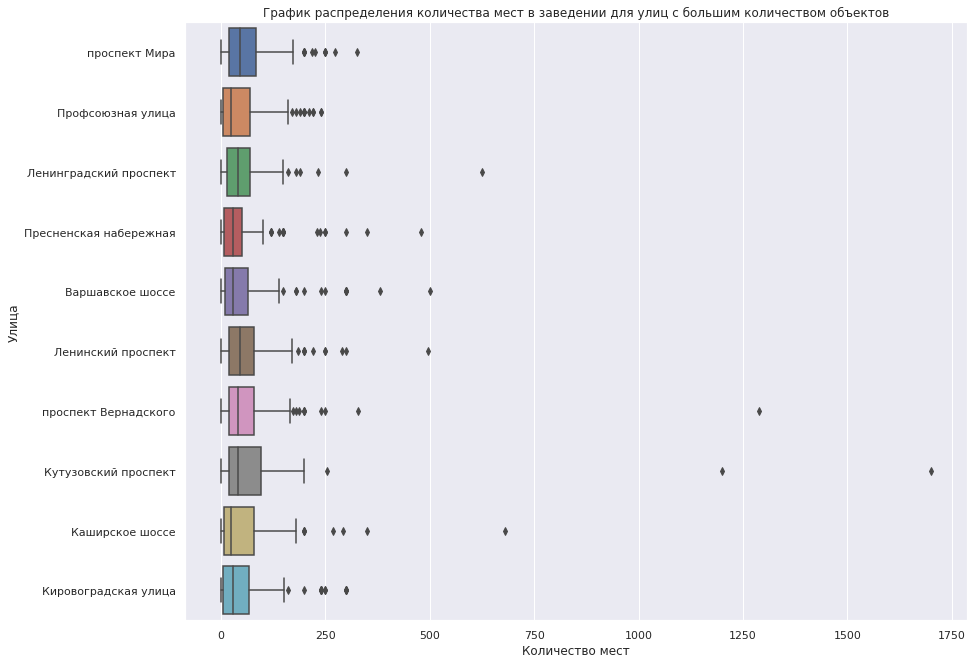

In [31]:
plt.figure(figsize=(14, 11))
sns.boxplot(y='street', x='number', data=number_assigment, order=df_gr_street.head(10)['street'].tolist())
plt.title('График распределения количества мест в заведении для улиц с большим количеством объектов')
plt.ylabel('Улица')
plt.xlabel('Количество мест')
plt.show()

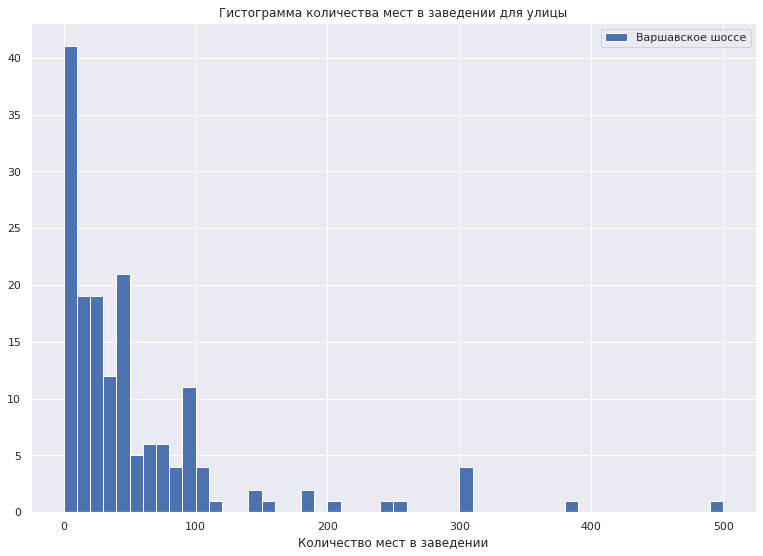

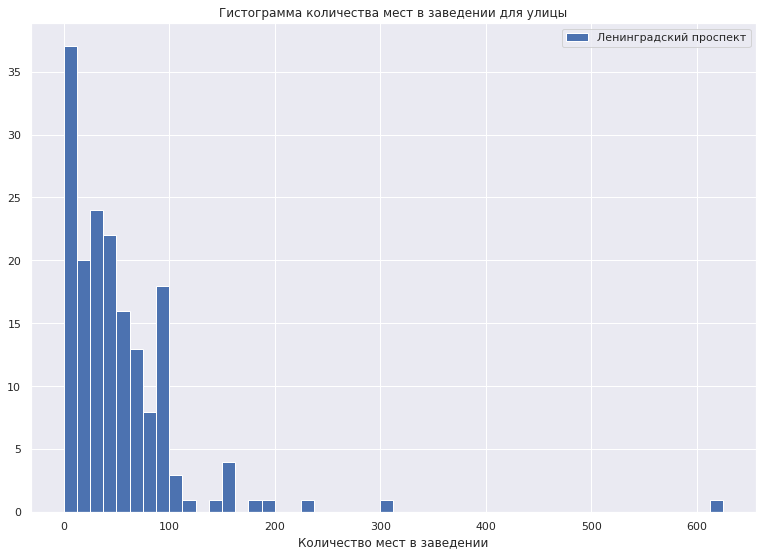

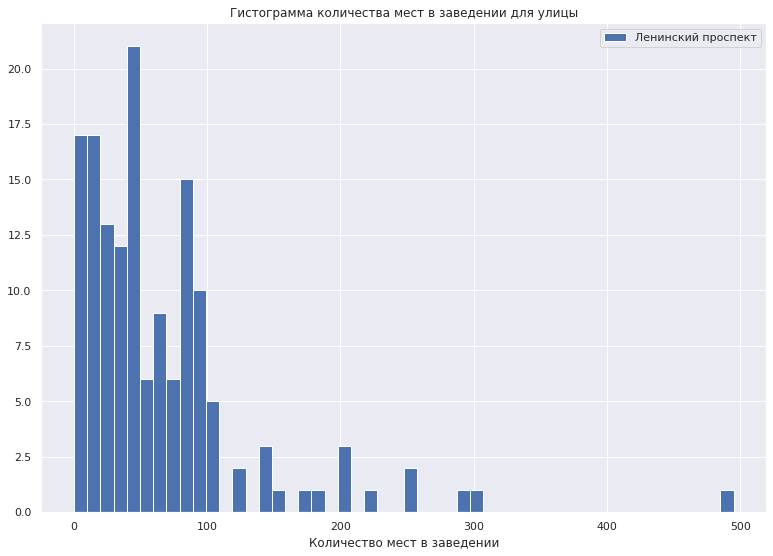

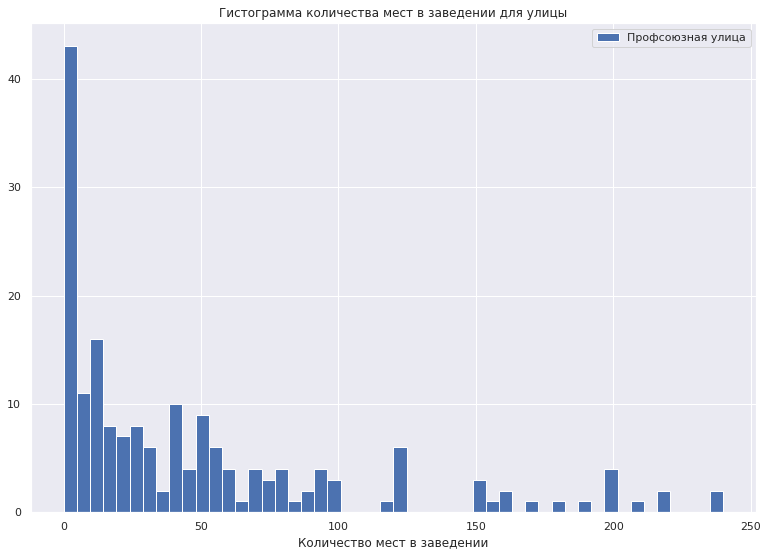

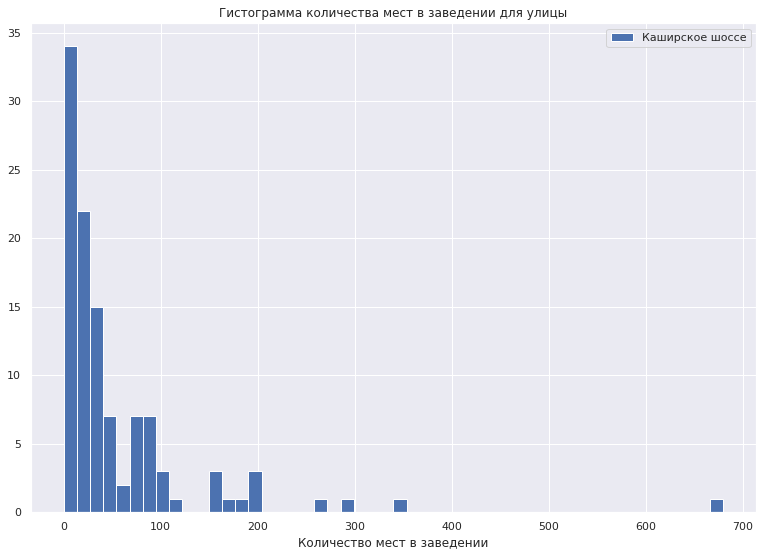

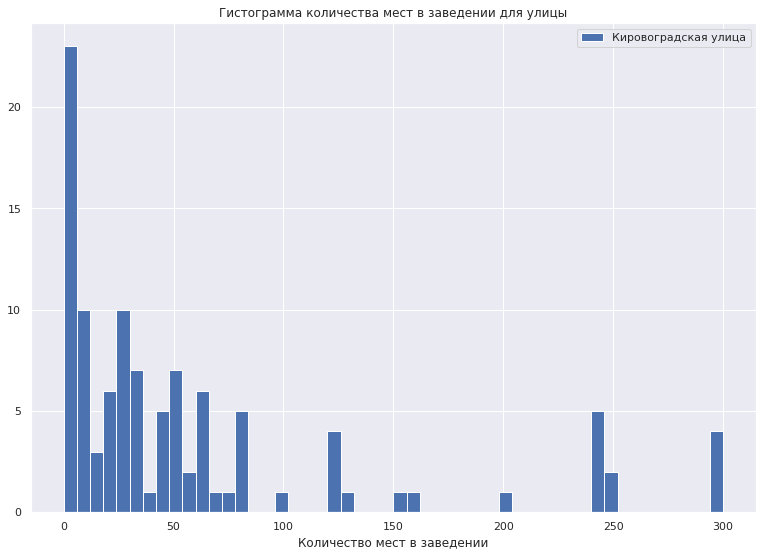

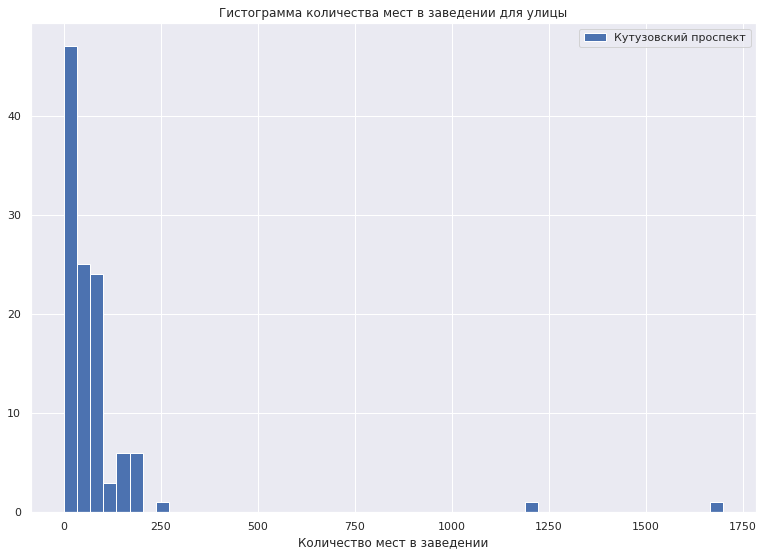

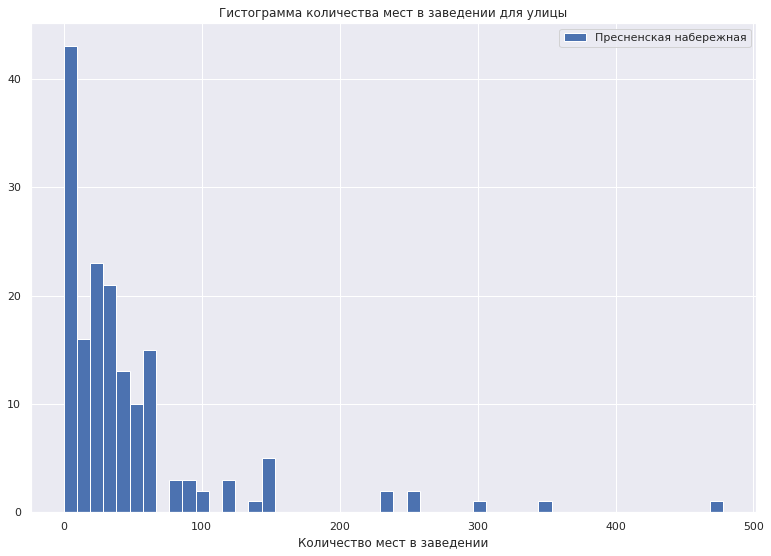

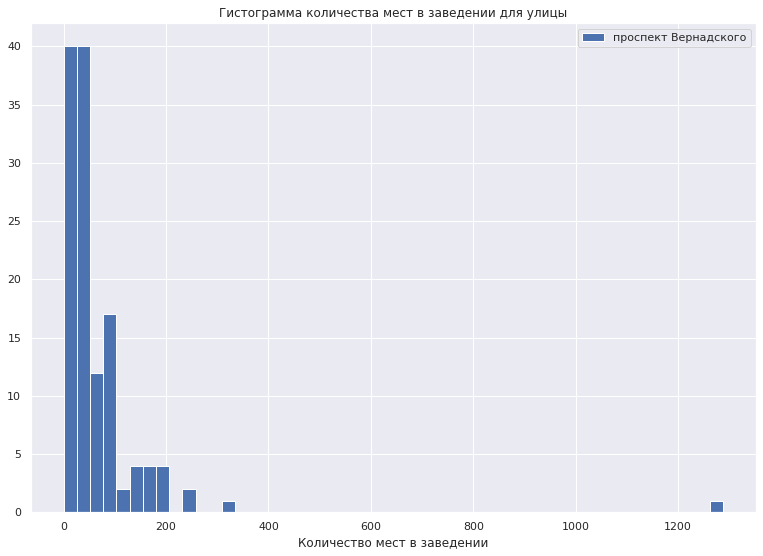

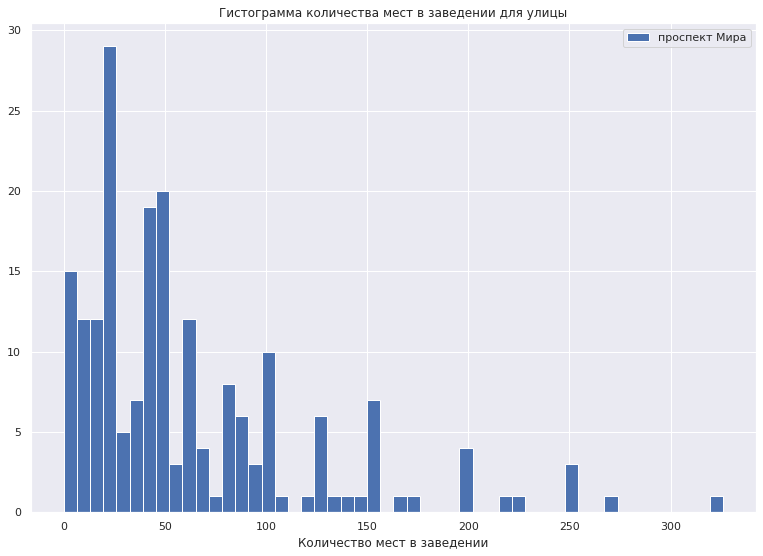

In [32]:
for i in list(number_assigment['street'].unique()):
    plt.figure(figsize=(13, 9))
    plt.hist(number_assigment[number_assigment['street'] == i]['number'], 
    bins=50,
    label=i,)
    plt.title('Гистограмма количества мест в заведении для улицы')
    plt.xlabel('Количество мест в заведении')
    plt.legend()
    plt.show()

Преобладающее большинство заведений в данных районах организованны по принципу небольшой величины. В условиях высокой конкуренции и дорогой аренды наиболее опитамальны небольшие по размеру заведения общественного питания.

###  Вывод и рекомендации

Для успешности нового Московского заведения, следует организовать его по типу кафе, ему следует быть небольшого размера с небольшим количеством мест для поситителей, а  располагаться лучше всего вблизи крупных улиц, шоссе и проспектов, даже несмотря на высокую конкуренцию можно полагаться на высокий трафик поситителей в таких людных местах. Возможно дальнейшее превращение в сеть, следует дополнительно открыть несколько крупных кафе.

## Подготовка призентации

Презентация: <https://disk.yandex.ru/i/VGzvL-rQeTT-_A> 